In [3]:
# Libraries imports
import numpy as np
import matplotlib.pyplot as plt
import cv2, skimage, os, sys
from collections import deque

%load_ext autoreload
%autoreload 2

In [4]:
# Local imports
from src import saliancy_map as sm
from src import utils
from src import optimization as opt
from src import database as db
from manippulating_saliency_main import phi, update_taus, manipulate_saliency

print('Model loaded.')

96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864
Model loaded.


# Initialisation

In [5]:
# User Input
image_path = './data/debug/easy_apple_small.jpg'
mask_path = './data/debug/easy_apple_small_mask.jpg'
delta_s = 0.8

# Constants
EPSILON = 1e-3

# Modular Definitions
compute_saliency_map = sm.tempsal_saliency
minimize_J = opt.minimize_J_global_poisson
compute_database = db.compute_location_database


Image size: (447, 700, 3)


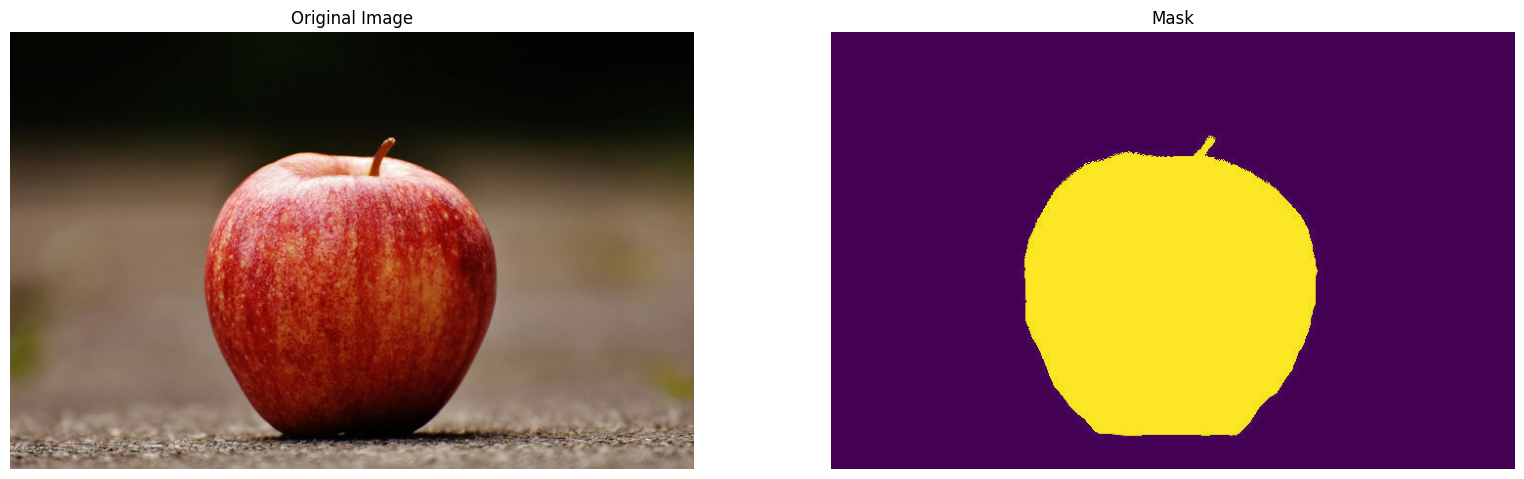

In [6]:
# Read the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print("Image size:", img.shape)

mask_image = cv2.imread(mask_path)
mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)[:,:]


utils.display_images([img, mask_image], titles=['Original Image', 'Mask'])

# Saliency Manipulation

In [7]:
# Initialize tau +/-
tau_positive = 0.2
tau_negative = 0.05
prev_tau_positive = tau_positive
prev_tau_negative = tau_negative

J_in = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
J_out = np.array([])

#### Partial Algorithm

You must do the iteration yourself :) 

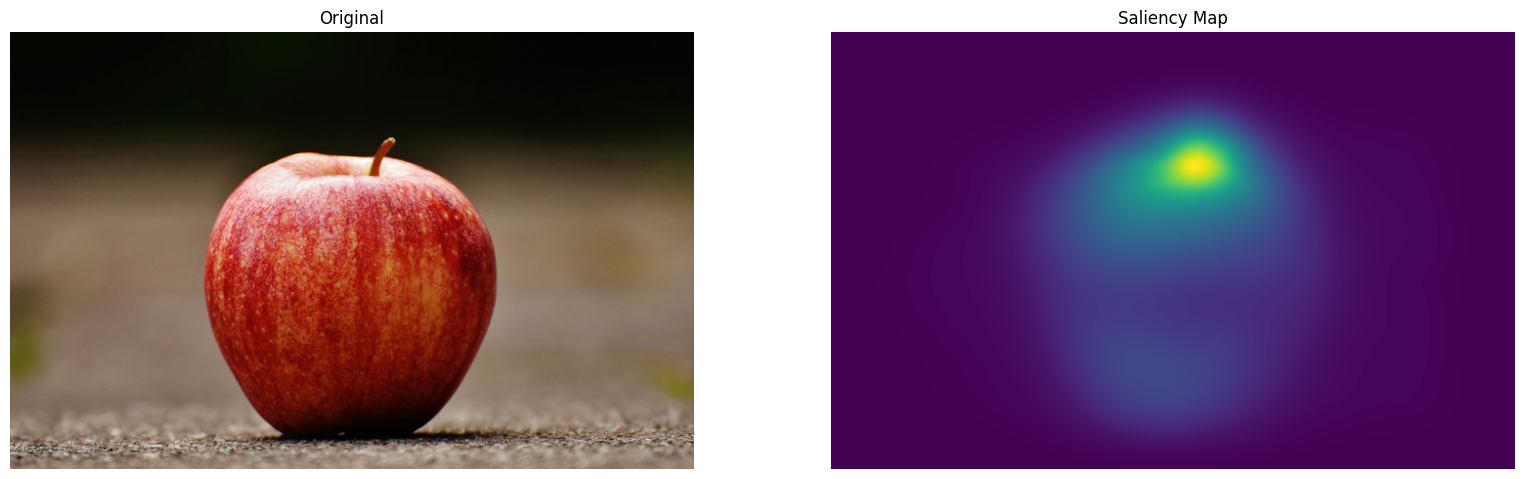

In [8]:
# Compute Saliency
s_map = compute_saliency_map(J_in)

utils.display_images([img, s_map], ['Original', 'Saliency Map'])

DB+ size: 33469, DB- size: 215630


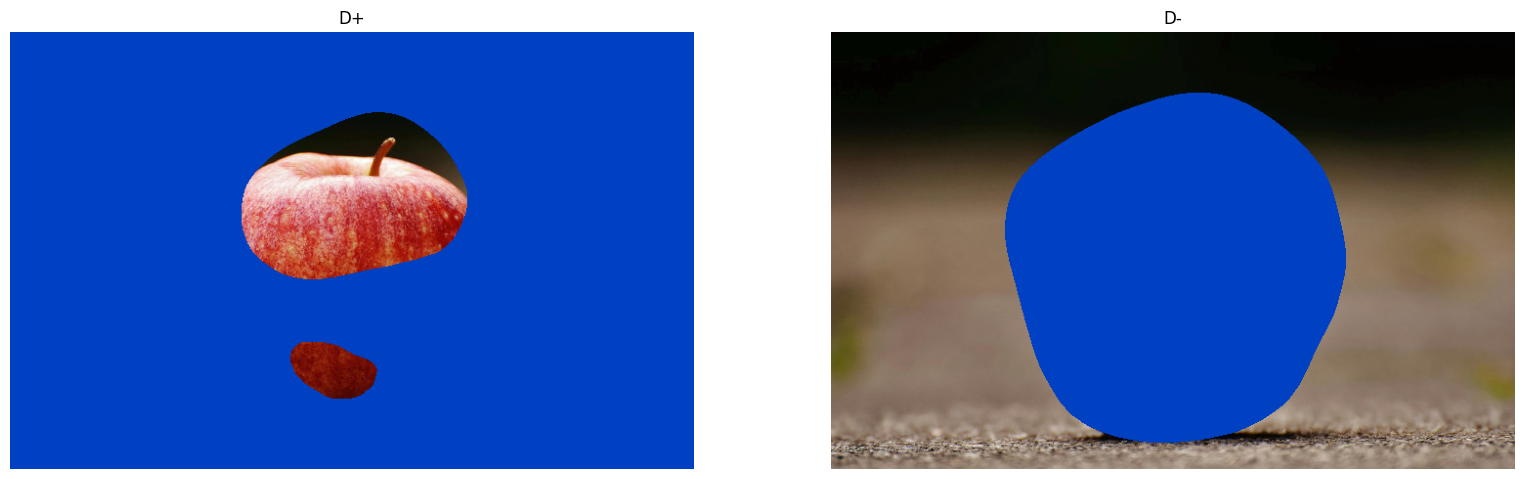

In [9]:
# DB update
D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
print(f"DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")

# Construct and display the database's images
I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

utils.display_images([I_D_positive, I_D_negative], ['D+', 'D-'])

Search-and-vote

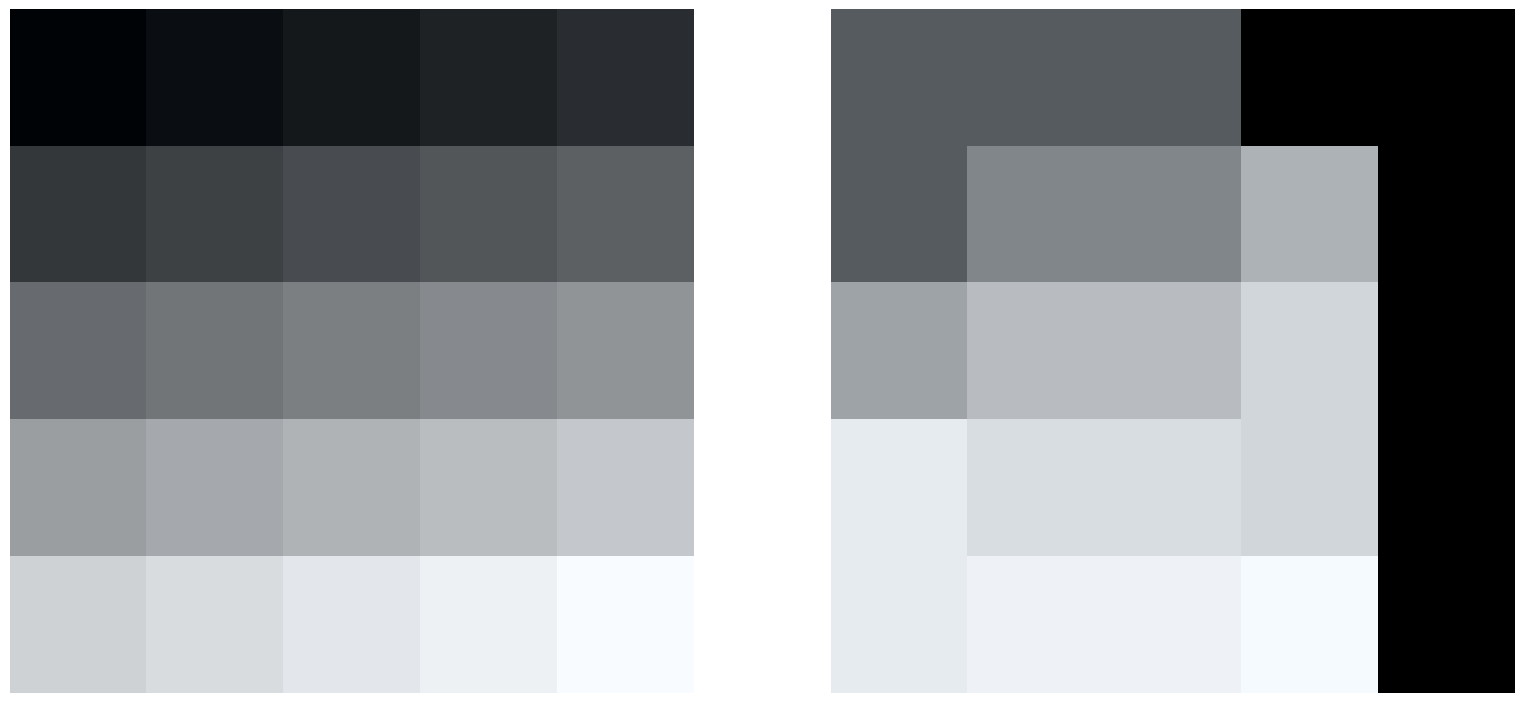

In [10]:
a = np.arange(75).reshape((5,5,3)) / 74
searched_patches_map = np.zeros((5,5,4))
patch_size=5
p_idxs = np.indices((3,3)).reshape(2, -1).T -1
for x in range(1,a.shape[0]-1, 2):
    for y in range(1, a.shape[1]-1, 2):
        x = np.random.randint(1,a.shape[0]-1)
        y = np.random.randint(1,a.shape[1]-1)
        p = a[x-1:x+2, y-1:y+2]
        s = searched_patches_map[x-1:x+2, y-1:y+2]

        # new_mean (per pixel) = temp_mean * N/(N+p*p) + p_mean / N+p*p
        n_plus_p2 = (s[:,:,3] + patch_size**2)
        s[:,:,:-1] *= (s[:,:,3] / n_plus_p2)[:,:,None]
        s[:,:,:-1] += np.ones_like(p) * p.sum(axis=(0,1)) / n_plus_p2[:,:,None]
        s[:,:,-1] = n_plus_p2.copy()
        

b = searched_patches_map[:,:,0:3]
b /= b.max()
utils.display_images([a,b])

In [28]:
# PATCHMATHC = SEARCH

patch_size = 7
stride = 3

width, height, _ = J_in.shape
radius = patch_size // 2

# Pad the image so that the patch don't overlap. (dont look, just know it works)
J_paded = np.stack([np.pad(J_in[:,:,i], radius, mode="reflect") for i in range(3)]).transpose(1,2,0)

# Create the mapping from a pixel location to (the current mean of the overlapping patches, number of elements. 
searched_patches_map = np.zeros((J_paded.shape[0], J_paded.shape[1], 4)) # 4 = (curr_r_mean, curr_g_mean, curr_b_mean, # seen pixels)

# Loop through all centers of each patch
for x in range(0, width, stride):
    for y in range(0, height, stride):
        # Because of pading, (x, y) actualy reprensent top left corner of patch 
        patch = J_paded[x:x+patch_size, y:y+patch_size]

        if mask_image[x, y] > 0 and len(D_positive) > 0:
            # Inside the mask (more salient)
            best_match = opt.find_best_match(patch, D_positive, J_paded)

        elif len(D_negative) > 0:
            # Outside the mask (less salient)
            best_match = opt.find_best_match(patch, D_negative, J_paded)
        else:
            best_match = patch  # If DB is empty keep orignal patch
        
        # VOTING STEP (but done on the fly)

        s = searched_patches_map[x:x+patch_size, y:y+patch_size]

        # TODO: filter out what is not in the "corect" given region
        # new_mean (per pixel) = temp_mean * N/(N+p*p) + p_mean / N+p*p
        n_plus_p2 = (s[:,:,3] + patch_size**2)
        s[:,:,:-1] *= (s[:,:,3] / n_plus_p2)[:,:,None]
        s[:,:,:-1] += np.ones_like(best_match) * best_match.sum(axis=(0,1)) / n_plus_p2[:,:,None]
        s[:,:,-1] = n_plus_p2.copy()

# Unpad the image
J_patched_padded = searched_patches_map[:, :, :-1]

# Put back in range [0, 255]
J_patched_padded = np.floor(J_patched_padded).astype(np.uint8)

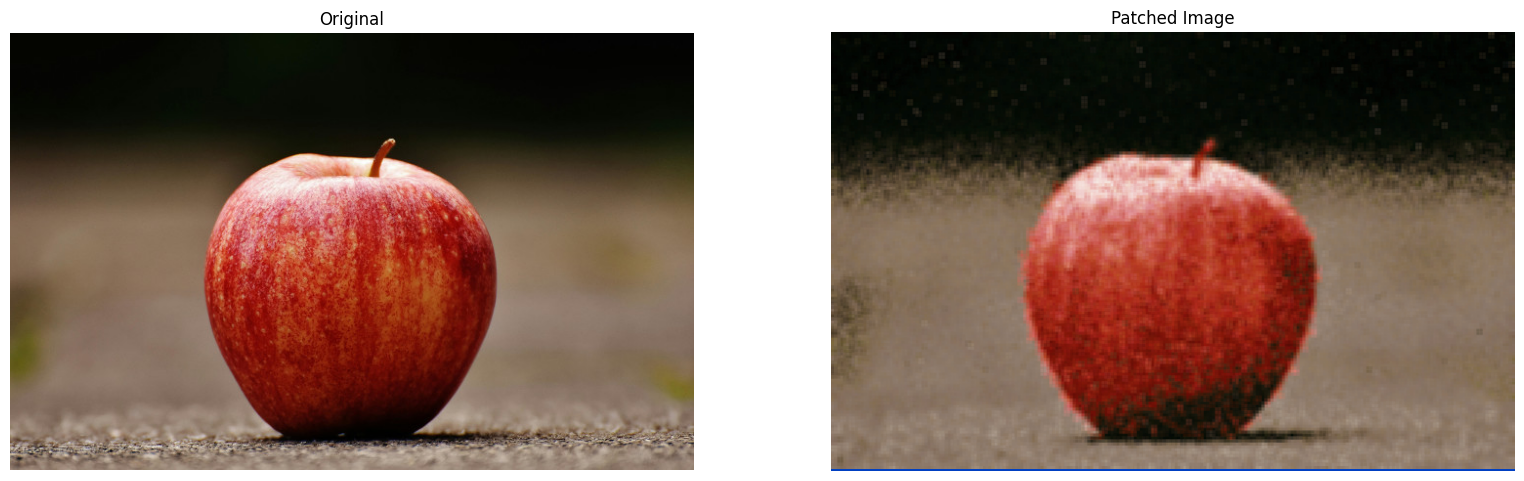

In [29]:
# Display patchMatch
J_patched_rgb = cv2.cvtColor(J_patched_padded, cv2.COLOR_Lab2RGB)
utils.display_images([img, J_patched_rgb], ['Original', 'Patched Image'])

Recursive patchy


In [24]:
from collections import deque
import numpy as np

def get_flat_layer_index(x, y, patch_size):
    return (x % patch_size) + patch_size * (y % patch_size)

def extract_patch(image, x, y, patch_size):
    r = patch_size // 2
    return image[x - r:x + r + 1, y - r:y + r + 1]

def in_bounds(x, y, shape, patch_size):
    r = patch_size // 2
    return r <= x < shape[0] - r and r <= y < shape[1] - r

def vote_patch(searched_patches_map, patch, x, y):
    """Patch-wise vote with real spatial patch blending"""
    r = patch.shape[0] // 2
    region = searched_patches_map[x - r:x + r + 1, y - r:y + r + 1]

    n = region[:, :, 3:4] + 1
    region[:, :, :3] = (region[:, :, :3] * region[:, :, 3:4] + patch) / n
    region[:, :, 3:4] = n

def bfs_patchmatch(x0, y0, J, mask, patch_size, D_positive, D_negative, image_layers, max_depth=999, mode='auto'):
    H, W, _ = J.shape
    visited = np.zeros((H, W), dtype=bool)
    queue = deque()
    queue.append((x0, y0, 0))

    while queue:
        x, y, depth = queue.popleft()
        if not in_bounds(x, y, J.shape[:2], patch_size) or visited[x, y] or depth > max_depth:
            continue

        visited[x, y] = True
        patch = extract_patch(J, x, y, patch_size)

        if mode == 'auto':
            if mask[x, y] > 0 and len(D_positive) > 0:
                best = opt.find_best_match(patch, D_positive, J)
            elif len(D_negative) > 0:
                best = opt.find_best_match(patch, D_negative, J)
            else:
                best = patch
        else:
            db = D_positive if mode == 'pos' else D_negative
            best = opt.find_best_match(patch, db, J)

        layer_id = get_flat_layer_index(x, y, patch_size)
        vote_patch(image_layers[layer_id], best, x, y)

        for dx, dy in [(-patch_size, 0), (patch_size, 0), (0, -patch_size), (0, patch_size)]:
            queue.append((x + dx, y + dy, depth + 1))

def merge_layers(image_layers):
    H, W, _ = image_layers[0].shape
    final = np.zeros((H, W, 3), dtype=np.float32)
    weight = np.zeros((H, W, 1), dtype=np.float32)

    for layer in image_layers:
        final += layer[:, :, :3]
        weight += layer[:, :, 3:4]

    final = final / np.maximum(weight, 1e-5)
    return np.clip(final, 0, 255).astype(np.uint8)


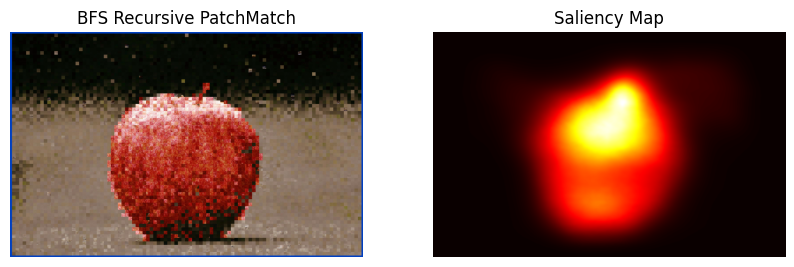

In [25]:
# Parameters
PATCH_SIZE = 7
MAX_DEPTH = 999

# Input image: assume J_in = Lab image and mask_image binary mask
H, W, _ = J_in.shape
num_layers = PATCH_SIZE ** 2

# Initialize image_layers
image_layers = [np.zeros((H, W, 4), dtype=np.float32) for _ in range(num_layers)]

# Start BFS from center
center_x, center_y = H // 2, W // 2
bfs_patchmatch(center_x, center_y, J_in, mask_image, PATCH_SIZE, D_positive, D_negative, image_layers, max_depth=MAX_DEPTH)

# Merge result
J_merged = merge_layers(image_layers)

# Show result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(J_merged, cv2.COLOR_Lab2RGB))
plt.title("BFS Recursive PatchMatch")
plt.axis("off")

plt.subplot(1, 2, 2)
s_map = compute_saliency_map(cv2.cvtColor(J_merged, cv2.COLOR_Lab2RGB))
plt.imshow(s_map, cmap="hot")
plt.title("Saliency Map")
plt.axis("off")
plt.show()


In [33]:
# Compute saliency maps
sal_before = compute_saliency_map(img)
sal_after = compute_saliency_map(J_merged)

# Compute mean saliency inside and outside mask
s_before_fg = np.mean(sal_before[mask_image > 0])
s_before_bg = np.mean(sal_before[mask_image == 0])
s_after_fg = np.mean(sal_after[mask_image > 0])
s_after_bg = np.mean(sal_after[mask_image == 0])

print("Before: ΔS =", round(s_before_fg - s_before_bg, 4))
print("After:  ΔS =", round(s_after_fg - s_after_bg, 4))

Before: ΔS = 0.267
After:  ΔS = 0.3445


Poisson Screening

In [31]:
poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=5.)

# un-pad the image
J_out = np.floor(poisson_padded[radius:width+radius, radius:height+radius]).astype(np.uint8)

error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


In [13]:
# Display Resutls
J_out_rgb = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)
diff = np.abs(img - J_out_rgb).mean(axis=2) / 255
print(diff.min(), diff.max())
utils.display_images([img, J_out_rgb, diff], ['Original', 'Modified Saliency', 'diff'])


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


##### Poisson lambda factor test

In [15]:
poissons = []
lambdas = np.logspace(-5,0, 6) * 5

for l in lambdas:
    poisson_padded = opt.screen_poisson(J_paded, J_patched_padded, lambda_factor=l)

    # un-pad the image
    poissons.append(np.floor(poisson_padded[radius:-radius, radius:-radius]).astype(np.uint8))


error: OpenCV(4.11.0) D:/a/opencv-python/opencv-python/opencv/modules/imgproc/src/filter.simd.hpp:3252: error: (-213:The function/feature is not implemented) Unsupported combination of source format (=1), and destination format (=6) in function 'cv::opt_AVX2::getLinearFilter'


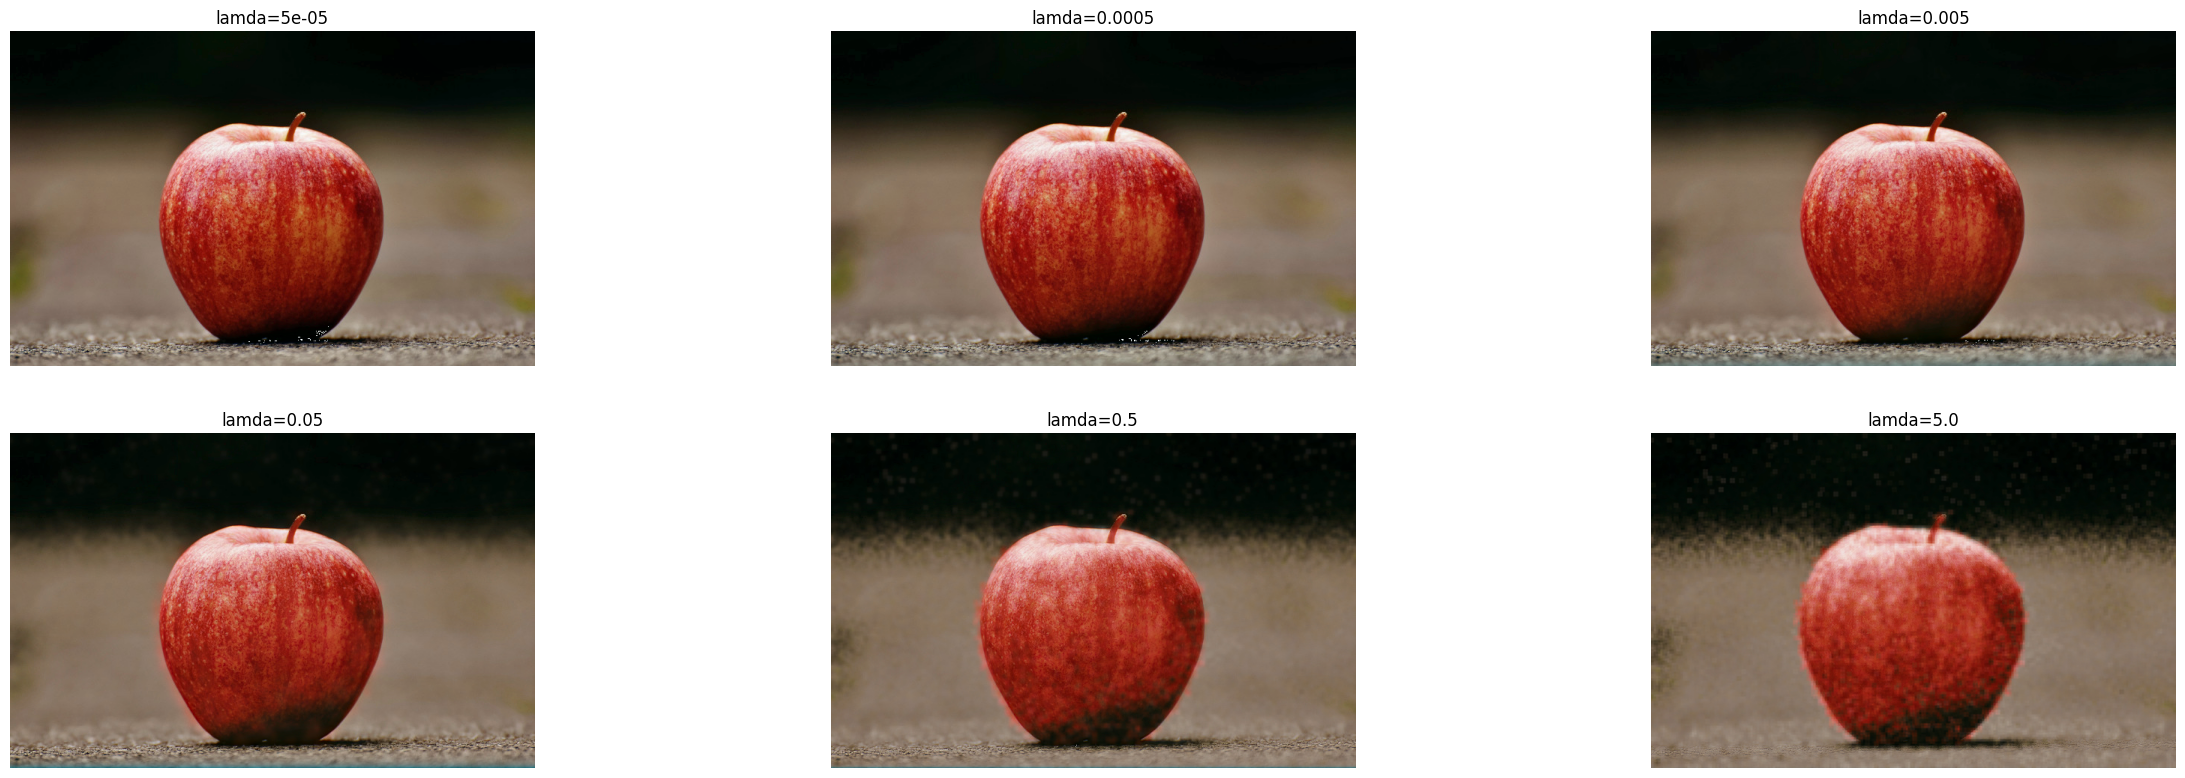

In [106]:
# Display results
utils.display_images([cv2.cvtColor(p, cv2.COLOR_Lab2RGB) for p in poissons], [f'lamda={l}' for l in lambdas])

(un-comment if you want to manualy iterate)

In [ ]:
# # switch the buffers
# temp = J_in.copy()
# J_in = J_out
# J_out = J_in

# # Update tau +/-
# tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)
# print(f'\n4Tau+: {tau_positive}, Tau-: {tau_negative}')


#### Full Algorithm

In [117]:
nb_iterations = 1

print("Begin Saliency Manipulation:")

# while compute_criterion(S_J, R, delta_s) > EPSILON:
for x in  range(nb_iterations):
    print(f"Iteration {x}")
    # update the saliency map
    print(" - computing Saliency...")
    s_map = compute_saliency_map(J_in)
    print(" - Done.")

    # DB update
    print(" - computing DB...")
    D_positive, D_negative = compute_database(tau_positive, tau_negative, J_in, s_map)
    print(f" - Done, DB+ size: {D_positive.shape[0]}, DB- size: {D_negative.shape[0]}")
    
    # Construct and display the database's images
    I_D_positive, I_D_negative = db.compute_image_database(J_in, D_positive, D_negative)

    # utils.display_images([S_J, I_D_positive, I_D_negative])

    # update J to minimize the energy function
    print(" - Minimizing function...")
    J_out = minimize_J(J_in, mask_image, D_positive, D_negative)
    print(" - Done.")
    # Update tau +/-
    tau_positive, tau_negative = update_taus(tau_positive, tau_negative, s_map, mask_image, delta_s)

    # switch the buffers (only affect the references so no copy is made)
    temp = J_in.copy()
    J_in = J_out
    J_out = J_in

    # Check if convergence is reached by tau's
    tau_diff = abs(tau_positive - prev_tau_positive) + abs(tau_negative - prev_tau_negative)
    prev_tau_positive, prev_tau_negative = tau_positive, tau_negative
    if tau_diff < EPSILON:
        break

    # print("\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K\033[A\033[K", end="")
    
# Cancel the last input-output exchange
temp = J_in.copy()
J_in = J_out
J_out = J_in

print("Done")
J_out = cv2.cvtColor(J_out, cv2.COLOR_Lab2RGB)

Begin Saliency Manipulation:
Iteration 0
 - computing Saliency...
 - Done.
 - computing DB...
 - Done, DB+ size: 33469, DB- size: 215630
 - Minimizing function...
  - Applying PatchMatch...
  - Applying Poisson Screening... - Done.
Done


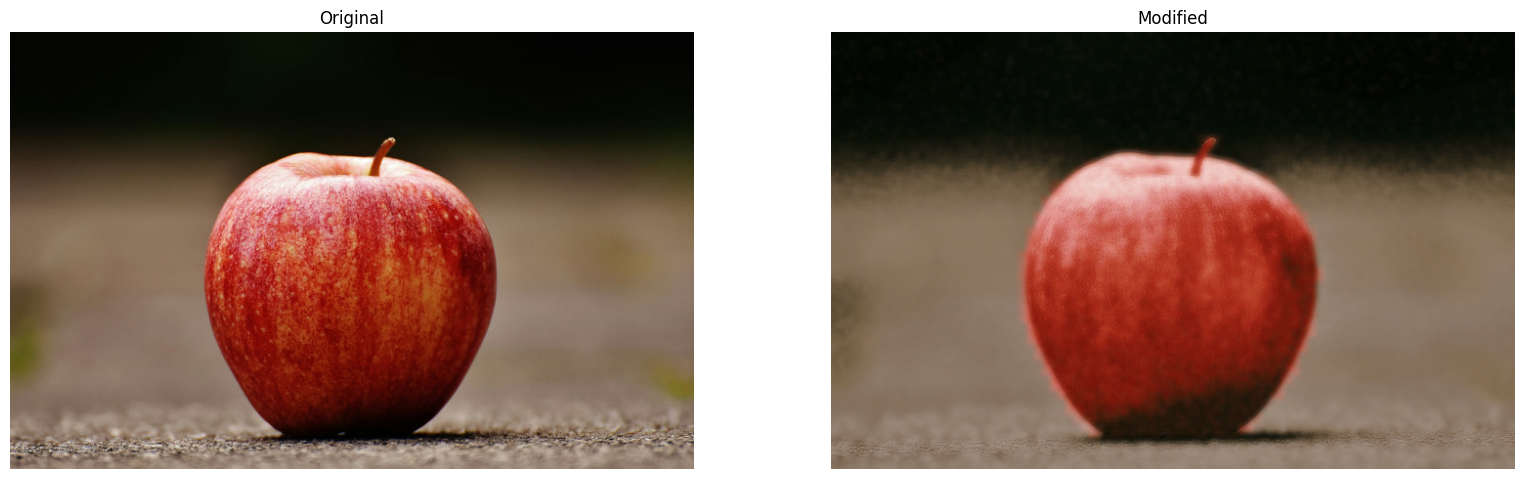

In [118]:
# Display results
utils.display_images([img, J_out], ['Original', 'Modified'])